In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import pandas as pd 
import os 
import numpy as np 
import sys  
sys.path.append("../")
from features import feature_analysis
from utils import analysis_utils
import matplotlib.pyplot as plt 
import seaborn as sns

In [117]:
outputdir = "../output/evaluation/processed"
projects = ['Lang', 'Math', 'Time', 'Closure', 'Cli', 'Compress', 'Codec', 'Collections', 'Csv', 
    'JacksonCore', 'JacksonXml', 'JxPath', 'Jsoup']
featuredir = "../output/evaluation/features"
DEV_FEATURE_TYPES = ['l_churn', 'e_churn', 'l_min_age', 'l_max_age', 'e_min_age', 'e_max_age', 'l_n_authors', 'e_n_authors']
DEV_FEATURE_TYPES_L = {
 'l_churn':"churn$^l$",
 'l_min_age':"age$^l_{min}$",
 'l_max_age':"age$^l_{max}$",
 'l_n_authors':"n$^l_{dev}$",
 'e_churn':"churn$^e$",
 'e_min_age':"age$^e_{min}$",
 'e_max_age':"age$^e_{max}$",
 'e_n_authors':"n$^e_{dev}$"
}

# Change Features

In [17]:
n_feature_df_pproj = feature_analysis.get_feature_per_project(projects, os.path.join(featuredir, "all_muts"), DEV_FEATURE_TYPES, norm = True, all_muts = True)
n_rv_feature_df_pproj = feature_analysis.get_feature_per_project(projects, featuredir, DEV_FEATURE_TYPES, norm = True)

### code change feature: live vs killed vs latent

In [71]:
sns.set_style("whitegrid")

In [67]:
def plot_chgfdistr(df, title, hue_order):
    df_long = pd.melt(df, id_vars ='status', value_vars = DEV_FEATURE_TYPES) 
    fig, ax = plt.subplots(figsize = (6,6))
    g = sns.boxplot(data = df_long, x = 'variable', y = 'value', hue = 'status', ax = ax,
      showmeans=True,
      medianprops=dict(color="red", alpha=1.0),
      meanprops={"marker":"o",
          "markerfacecolor":"white", 
          "markeredgecolor":"black",
        "markersize":"6"}, palette = 'Set2', 
      hue_order= hue_order
      )
    g.legend(loc = 'upper right')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title)
    ax.set_xticklabels([DEV_FEATURE_TYPES_L[F] for F in DEV_FEATURE_TYPES], fontsize = 12, rotation = 30)
    fig.tight_layout()
    plt.show()

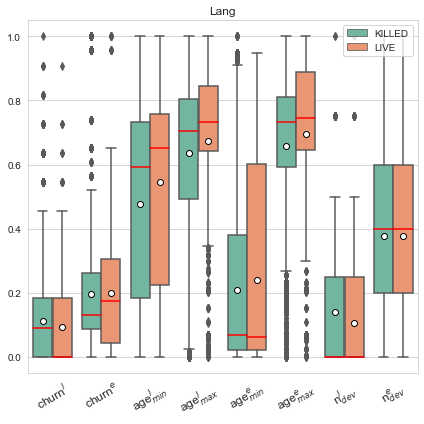

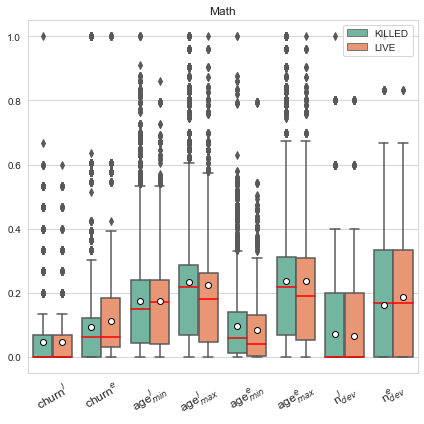

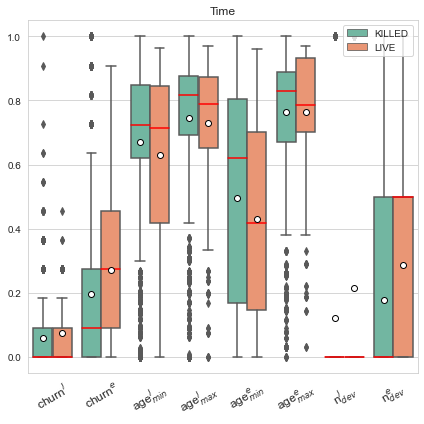

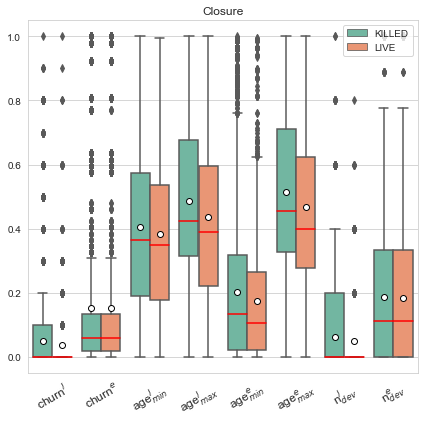

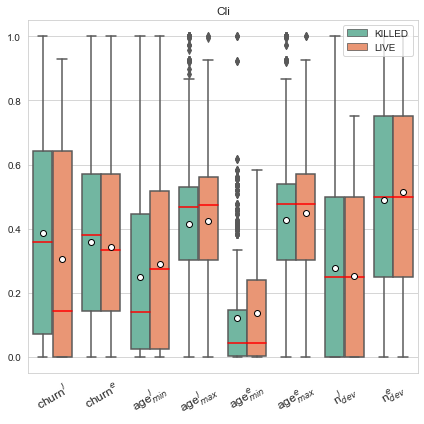

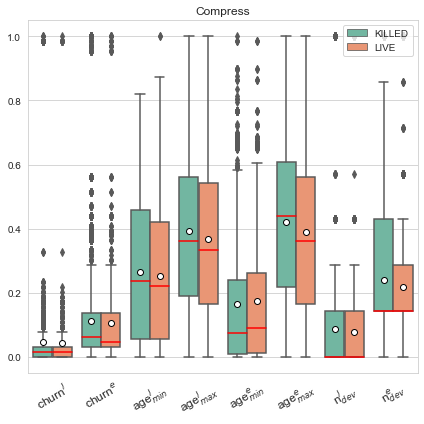

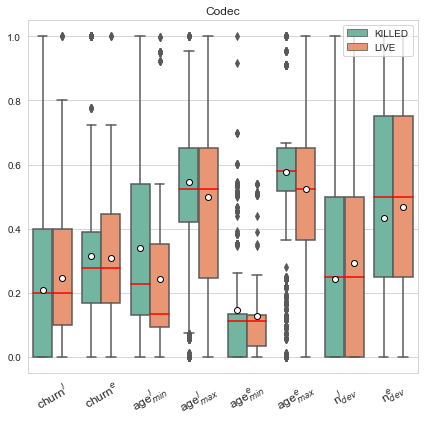

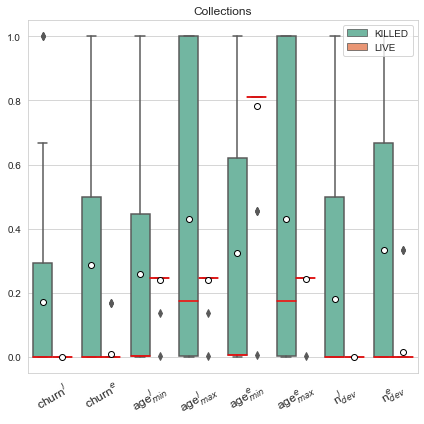

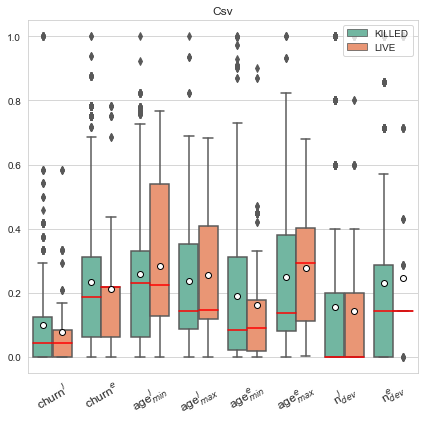

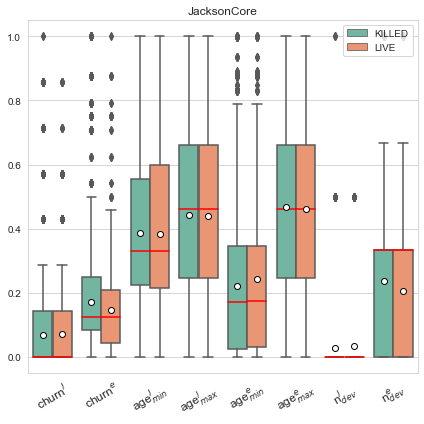

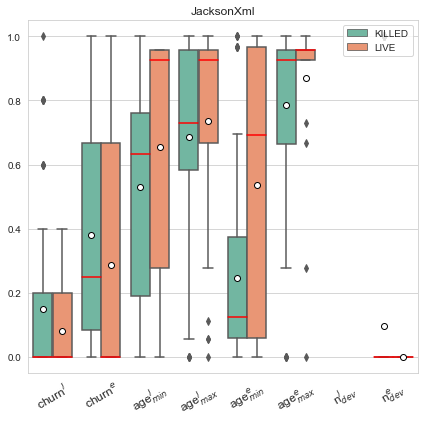

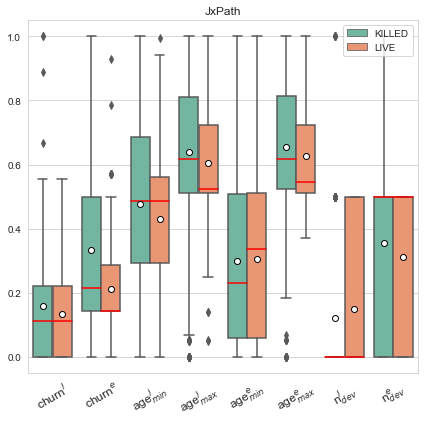

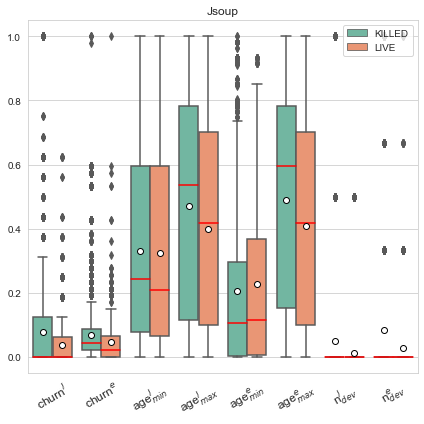

In [68]:
for project in projects:
    df = n_feature_df_pproj[project]
    df.loc[df.status == 'SURVIVED', 'status'] = 'LIVE' # rename 
    plot_chgfdistr(df, project, hue_order = ['KILLED', 'LIVE'])
  

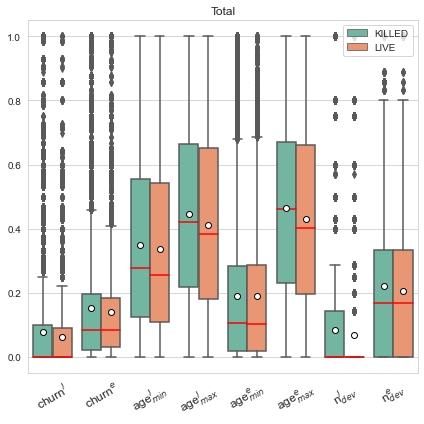

In [69]:
df = pd.concat(list(n_feature_df_pproj.values()))
df.loc[df.status == 'SURVIVED', 'status'] = 'LIVE' # rename 
plot_chgfdistr(df, 'Total', hue_order = ['KILLED', 'LIVE'])

### code change feature: latent vs non-latent vs discard

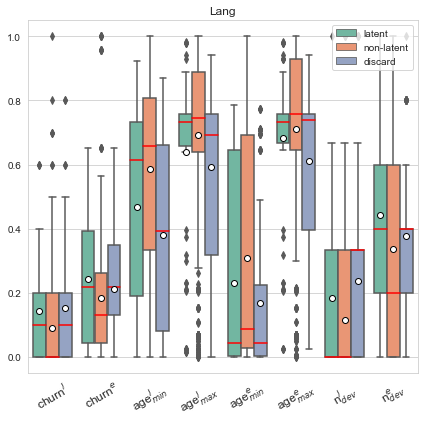

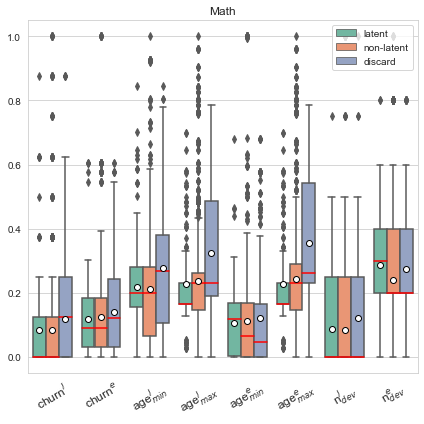

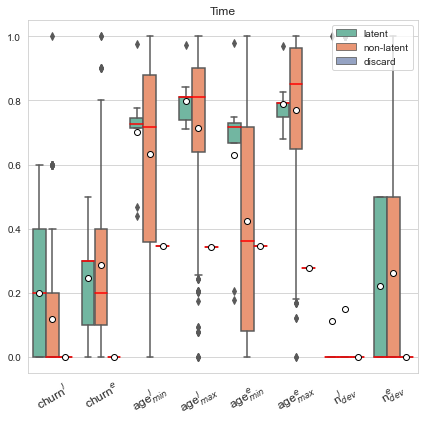

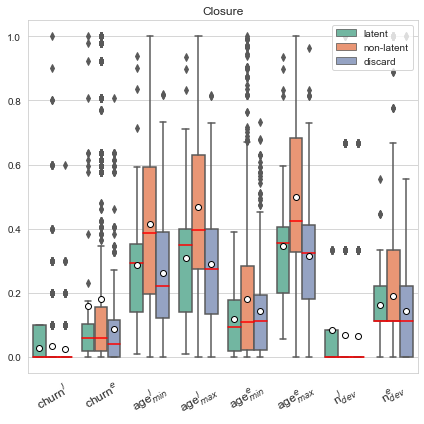

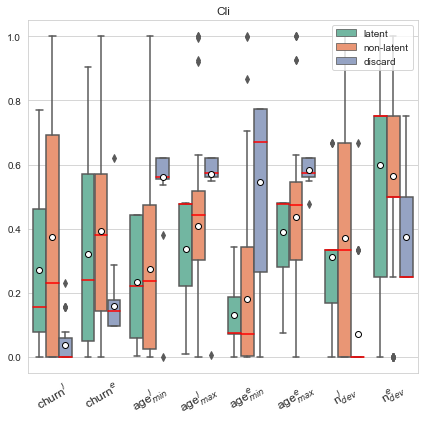

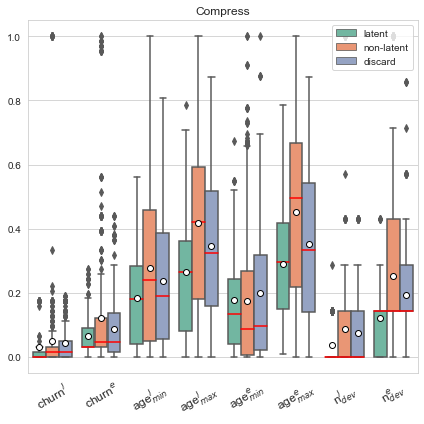

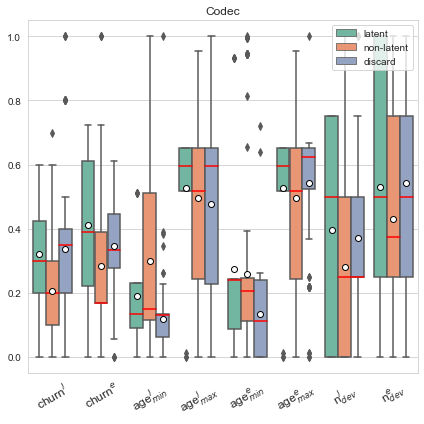

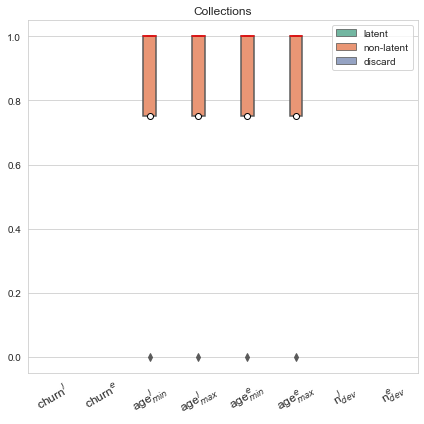

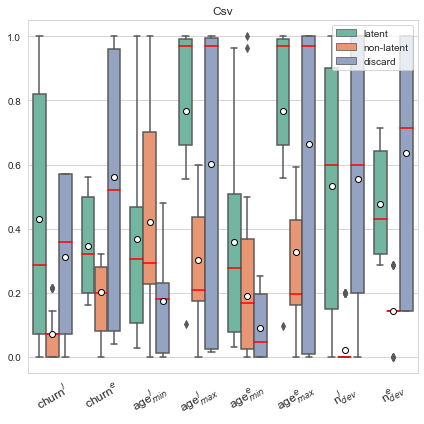

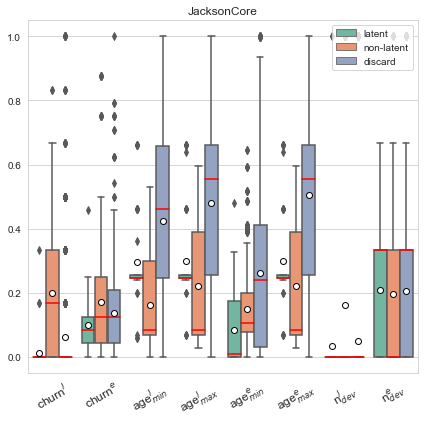

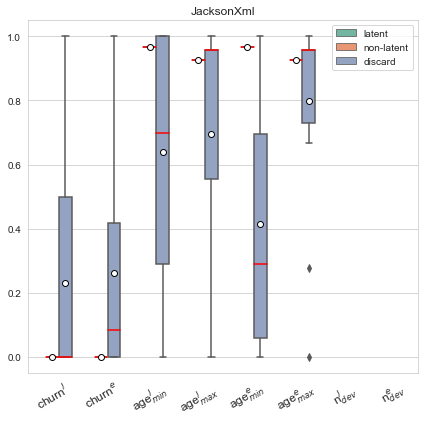

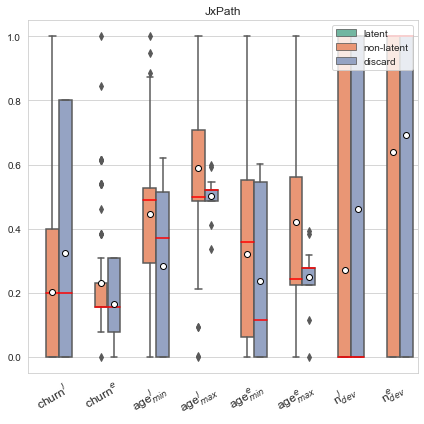

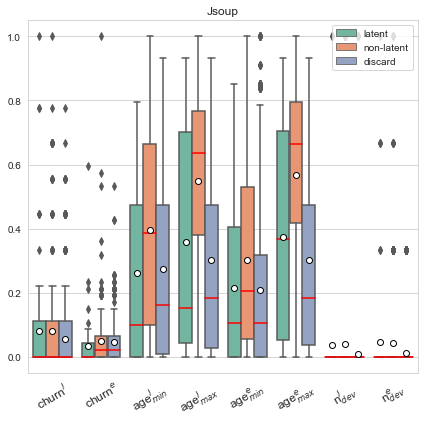

In [74]:
for project in projects:
    df = n_rv_feature_df_pproj[project]
    df.loc[df.status == 'reveal', 'status'] = 'latent'
    df.loc[df.status == 'surv', 'status'] = 'non-latent'
    df.loc[df.status == 'dead', 'status'] = 'discard'
    df_long = pd.melt(df, id_vars ='status', value_vars = DEV_FEATURE_TYPES)
    plot_chgfdistr(df, project, hue_order = ['latent', 'non-latent', 'discard'])

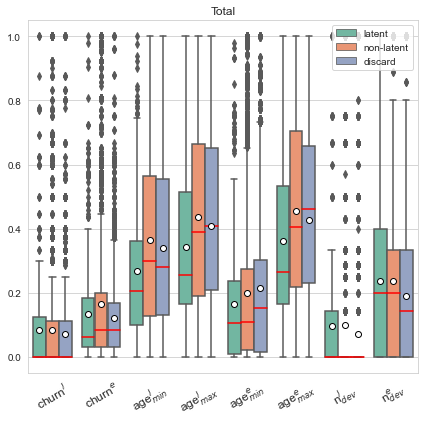

In [73]:
df = pd.concat(list(n_rv_feature_df_pproj.values()))
df_long = pd.melt(df, id_vars ='status', value_vars = DEV_FEATURE_TYPES)
plot_chgfdistr(df, 'Total', hue_order = ['latent', 'non-latent', 'discard'])

### Latent faults and the change types

In [50]:
os.environ['D4J_HOME'] = "../tools/defects4j"

In [102]:
# get revealing mutants info
import glob 
not_processed = {}
revealed_mut_infos = {}
for project in projects:
    _, revToBids = analysis_utils.getBidRevDict(os.getenv('D4J_HOME'), project)
    revealed_mut_infos[project] = []
    for fpath in glob.glob(os.path.join(outputdir, f"{project}*revealed_comp_mutinfo.pkl")):
        bid = int(os.path.basename(fpath).split(".")[1])
        df = pd.read_pickle(fpath)
        df = df.loc[df.revealed_mut_loc.apply(lambda v:len(eval(v)) > 0).values]
        adfs = []
        for mutK, adf in df.groupby('mutK'):
            adf = adf[adf.debt_time == adf.debt_time.min()]
            adfs.append(adf)
        df = pd.concat(adfs, ignore_index=True)
        df['bid'] = [bid] * len(df)
        revealed_mut_infos[project].append(df) 
    if len(revealed_mut_infos[project]) == 0:
        print (f"No revealing in {project}")
    else:
        revealed_mut_infos[project] = pd.concat(revealed_mut_infos[project], ignore_index=True)
        chg_state_vs = revealed_mut_infos[project].level.apply(lambda v:v.split("_")[0])
        revealed_mut_infos[project]['final_chg_state'] = chg_state_vs

No revealing in Collections
No revealing in JacksonXml
No revealing in JxPath


In [77]:
def categ_by_chg_status(df, chg_status):
    cnt_latent = ((df.final_chg_state == chg_status) & (df.status == 'latent')).sum()
    cnt_non_latent = ((df.final_chg_state == chg_status) & (df.status == 'non-latent')).sum()
    cnt_discard = ((df.final_chg_state == chg_status) & (df.status == 'discard')).sum()
    return (cnt_latent, cnt_non_latent, cnt_discard) 

In [112]:
# get change state
chg_state_df_pproj = {}
for chg_status in ['sc', 'rc', 'nc']:
    total_cnt_non_latent, total_cnt_latent, total_cnt_discard = 0, 0, 0 
    line = ""
    for project in projects: 
        chg_state_file = os.path.join(outputdir, f'{project}.chg_state.csv')
        chg_state_df = pd.read_csv(chg_state_file, index_col= False)
        mut_propa_stat_debt_file = os.path.join(outputdir, f"{project}.indv_mut_propagation_status_and_debt.csv")
        df = pd.read_csv(mut_propa_stat_debt_file, index_col=False)
        df = df.loc[~((df.status == 'latent') & (df.debt_time > 365))]
        df = df.loc[~((df.status == 'non-latent') & (df.debt_time <= 365))]
        cdf = chg_state_df.merge(df, on = ['bid', 'mutK'])
        cdf['project']= [project] * len(cdf)
        chg_state_df_pproj[project] = cdf

In [116]:
def cnt_status(df):
    cnt_latent = (df.status == 'latent').sum()
    cnt_non_latent = (df.status == 'non-latent').sum()
    cnt_discard = (df.status == 'discard').sum()
    return cnt_latent, cnt_non_latent, cnt_discard


## divide latent mutants based on their change type and the final category (chg type + revealed by direct/indirect changes)
def analy_mutants_by_type(project, chg_df, df, n_rev, decimal_point):
    line = project
    if len(df) == 0: return None # no-revealing 
    line = f"{project} & {n_rev}"
    grouped = df.groupby('final_chg_state')
    for state in ['sc', 'rc', 'nc']:
        cnt_latent, cnt_non_latent, cnt_discard = cnt_status(chg_df.loc[chg_df.final_chg_state == state])
        line += f" & {cnt_latent}/{cnt_non_latent}/{cnt_discard}"
        try:
            adf = grouped.get_group(state)
        except KeyError: # does not have this mutant state
            if state in ['sc', 'rc']:
                line += " & -- & -- & -- & -- & -- & --"
            else:
                line += " & -- & -- "
            continue 
        if state == 'sc':
            for level in ['sc_c', 'sc_nc']:
                aadf = adf.loc[adf.level == level]
                n = len(aadf)
                debt = np.round(aadf.debt_time.mean(), decimals= decimal_point) if n > 0 else 0.
                line += f" & {n} & {debt}"
            n = len(adf)
            debt = np.round(adf.debt_time.mean(), decimals= decimal_point) if n > 0 else 0.
            line += f" & {n} & {debt}"
        elif state == 'rc':
            for level in ['r_c', 'rc_nc']:
                aadf = adf.loc[adf.level == level]
                n = len(aadf)
                debt = np.round(aadf.debt_time.mean(), decimals= decimal_point) if n > 0 else 0.
                line += f" & {n} & {debt}"
            n = len(adf)
            debt = np.round(adf.debt_time.mean(), decimals= decimal_point) if n > 0 else 0.
            line += f" & {n} & {debt}"
        else:
            n = len(adf)
            debt = np.round(adf.debt_time.mean(), decimals= decimal_point) if n > 0 else 0.
            line += f" & {n} & {debt}"
    print (line + "\\\\")


In [115]:
decimal_point = 1
for project in projects:
    df = revealed_mut_infos['Lang']
    df = df.loc[df.debt_time <= 365] 
    analy_mutants_by_type(project, chg_state_df_pproj[project], df, chg_state_df_pproj[project].bid.unique().shape[0], decimal_point)
df = pd.concat([adf for adf in revealed_mut_infos.values() if not isinstance(adf, list)])
df = df.loc[df.debt_time <= 365]
chg_state_df = pd.concat(list(chg_state_df_pproj.values()))
analy_mutants_by_type('Total', chg_state_df, df, len(chg_state_df.groupby(['project', 'bid'])), decimal_point)

Lang & 27 & 1/44/25 & 1 & 1.5 & 0 & 0.0 & 1 & 1.5 & 3/3/4 & 0 & 0.0 & 0 & 0.0 & 3 & 2.0 & 35/571/147 & 35 & 111.6\\
Math & 79 & 15/171/30 & 1 & 1.5 & 0 & 0.0 & 1 & 1.5 & 0/0/0 & 0 & 0.0 & 0 & 0.0 & 3 & 2.0 & 121/660/445 & 35 & 111.6\\
Time & 10 & 0/2/0 & 1 & 1.5 & 0 & 0.0 & 1 & 1.5 & 0/0/0 & 0 & 0.0 & 0 & 0.0 & 3 & 2.0 & 5/71/1 & 35 & 111.6\\
Closure & 100 & 0/29/1 & 1 & 1.5 & 0 & 0.0 & 1 & 1.5 & 0/0/0 & 0 & 0.0 & 0 & 0.0 & 3 & 2.0 & 33/1639/540 & 35 & 111.6\\
Cli & 22 & 0/10/0 & 1 & 1.5 & 0 & 0.0 & 1 & 1.5 & 0/0/0 & 0 & 0.0 & 0 & 0.0 & 3 & 2.0 & 10/174/38 & 35 & 111.6\\
Compress & 43 & 2/41/43 & 1 & 1.5 & 0 & 0.0 & 1 & 1.5 & 0/0/1 & 0 & 0.0 & 0 & 0.0 & 3 & 2.0 & 24/503/475 & 35 & 111.6\\
Codec & 16 & 2/20/5 & 1 & 1.5 & 0 & 0.0 & 1 & 1.5 & 0/0/0 & 0 & 0.0 & 0 & 0.0 & 3 & 2.0 & 11/128/105 & 35 & 111.6\\
Collections & 2 & 0/0/0 & 1 & 1.5 & 0 & 0.0 & 1 & 1.5 & 0/0/0 & 0 & 0.0 & 0 & 0.0 & 3 & 2.0 & 0/4/0 & 35 & 111.6\\
Csv & 11 & 0/9/9 & 1 & 1.5 & 0 & 0.0 & 1 & 1.5 & 0/0/0 & 0 & 0.0 & 0 & 